In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
#import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

import ps

import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
import sys
sys.path.append('/home/ryohayama/python_current/BasicFeatureAnalysis')

import feature as F
import feature_collection as FC
import ps.joint_probability as psjp

In [3]:
def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

In [4]:
new_train = pd.read_csv('./data/trainset_112617.csv')
new_test = pd.read_csv('./data/test_112617.csv')

In [5]:
new_train.columns

Index(['id', 'target', 'calcs_set1', 'calcs_set2', 'ind_set1', 'ind_set2',
       'ind_set3', 'reg_set', 'car_set1', 'car_set2', 'car_set3'],
      dtype='object')

# No processing

In [6]:
pca = PCA()
X = pca.fit_transform(np.array(new_train.iloc[:, 2:]))
y = np.array(new_train.target)

Round1 Gini=0.361
Round2 Gini=0.375
Round3 Gini=0.367
Gini=0.367+/-0.006, Best=0.375
CPU times: user 3min 34s, sys: 289 ms, total: 3min 35s
Wall time: 28.4 s


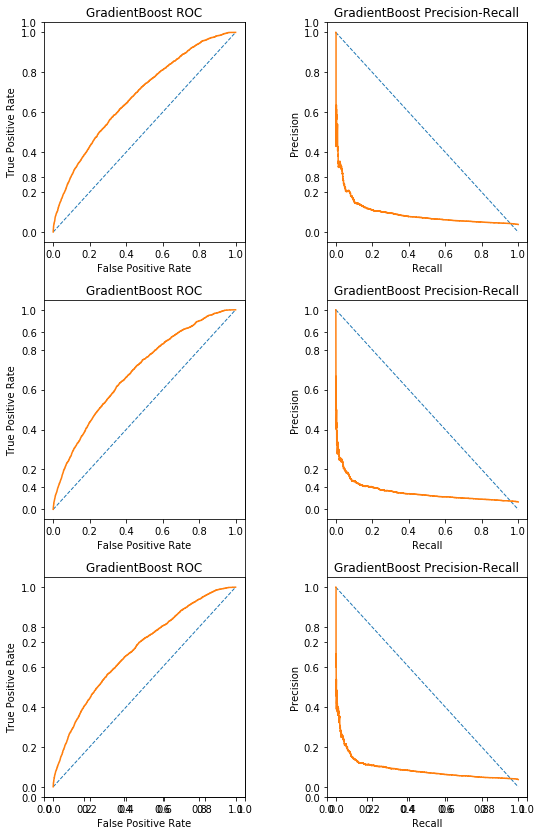

In [8]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 12))

neutral_line = np.linspace(0, 1, 10)

ginis = []
subplot_counter = 1

for i in range(3):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = XGBClassifier(gamma=15, subsample=0.85, max_depth=12, learning_rate=0.05,  
                        min_child_weight=4, n_estimators=200, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis.append(my_gini(y_test, y_proba2))
    print('Round%d Gini=%.3f' % (i+1, ginis[i]))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    
    ax1 = fig.add_subplot(3, 2, subplot_counter)
    ax2 = fig.add_subplot(3, 2, subplot_counter+1)
    
    ax1.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax2.plot(neutral_line, 1-neutral_line, lw=1, ls='--')
    
    ax1.plot(fpr2, tpr2)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('GradientBoost ROC')
    
    ax2.plot(recall2, precision2)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('GradientBoost Precision-Recall')
    
    subplot_counter += 2
    
plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis), np.std(ginis), np.max(ginis)))

# Tuning XGBoost

In [11]:
rstate = None

# Set targets for the number of each class
num_class1 = np.sum(y)
num_class1_to_resample = 2 * num_class1
num_class0_to_resample = int(1 * num_class1_to_resample)

# First, randomly undersample the majority
rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
X_tlrus, y_tlrus = rus.fit_sample(X, y)

# Then use SMOTE to oversample the minority
smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

## Gamma

<b>Round1</b>

In [12]:
%%time
xgb = XGBClassifier(max_depth=8, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
parameters = {'gamma':[0, 1, 2, 4, 8, 16, 32]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=3, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   49.0s finished


CPU times: user 6min 56s, sys: 87.9 ms, total: 6min 56s
Wall time: 52.4 s


In [13]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,2.182058,0.068621,0.414521,0.712806,1,{'gamma': 1},1,0.375686,0.747527,0.425287,0.711480,0.442594,0.679410,0.009022,0.000281,0.028356,0.027825
2,2.186682,0.063311,0.413888,0.696963,2,{'gamma': 2},2,0.378105,0.734086,0.424416,0.698001,0.439146,0.658802,0.024940,0.001789,0.026008,0.030743
0,2.268554,0.068407,0.413810,0.715468,0,{'gamma': 0},3,0.377620,0.751212,0.423666,0.711562,0.440146,0.683630,0.125243,0.000488,0.026460,0.027728
3,2.169108,0.054972,0.410296,0.640790,4,{'gamma': 4},4,0.376536,0.679251,0.419663,0.645725,0.434691,0.597393,0.012259,0.003277,0.024648,0.033600
4,2.159931,0.040422,0.400157,0.525100,8,{'gamma': 8},5,0.368638,0.566877,0.412690,0.520332,0.419144,0.488093,0.009566,0.002276,0.022442,0.032340
5,2.155734,0.023723,0.386434,0.433783,16,{'gamma': 16},6,0.362934,0.462274,0.398437,0.426518,0.397931,0.412556,0.012047,0.002348,0.016618,0.020937
6,2.193833,0.015634,0.376161,0.402505,32,{'gamma': 32},7,0.358751,0.421206,0.387475,0.398938,0.382257,0.387370,0.021982,0.001069,0.012494,0.014042


<b>Round2</b>

In [14]:
%%time
xgb = XGBClassifier(max_depth=8, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
parameters = {'gamma':[0.6, 0.8, 1, 1.2, 1.4]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=3, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   36.1s finished


CPU times: user 5min 14s, sys: 48.5 ms, total: 5min 14s
Wall time: 39.5 s


In [15]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,2.203056,0.068460,0.416845,0.712526,0.8,{'gamma': 0.8},1,0.380758,0.741925,0.425976,0.713953,0.443803,0.681701,0.016670,0.000498,0.026535,0.024607
0,2.263783,0.068407,0.416152,0.715990,0.6,{'gamma': 0.6},2,0.378339,0.746827,0.426994,0.708282,0.443125,0.692861,0.104495,0.001415,0.027537,0.022696
3,2.178538,0.066772,0.416047,0.709870,1.2,{'gamma': 1.2},3,0.377727,0.742116,0.429095,0.712071,0.441321,0.675422,0.006752,0.000593,0.027553,0.027272
4,2.176626,0.067328,0.414894,0.705987,1.4,{'gamma': 1.4},4,0.378615,0.741935,0.424277,0.705261,0.441793,0.670764,0.010325,0.002046,0.026632,0.029060
2,2.177625,0.067876,0.414521,0.712806,1,{'gamma': 1},5,0.375686,0.747527,0.425287,0.711480,0.442594,0.679410,0.015261,0.001726,0.028356,0.027825


## max_depth

<b>Round1</b>

In [22]:
%%time
xgb = XGBClassifier(gamma=0.8, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
parameters = {'max_depth':[20, 25, 30, 35, 40]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=3, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.2min finished


CPU times: user 19min 41s, sys: 337 ms, total: 19min 41s
Wall time: 2min 28s


In [23]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
3,9.139826,0.328566,0.546705,1.0,35,{'max_depth': 35},1,0.491891,1.0,0.528244,1.0,0.619986,1.0,0.045750,0.008148,0.053899,1.281975e-16
4,10.328242,0.358714,0.545480,1.0,40,{'max_depth': 40},2,0.491093,1.0,0.527780,1.0,0.617571,1.0,0.313842,0.008429,0.053129,0.000000e+00
2,8.095548,0.296074,0.543775,1.0,30,{'max_depth': 30},3,0.490839,1.0,0.526640,1.0,0.613852,1.0,0.008008,0.001206,0.051661,0.000000e+00
1,7.048442,0.257210,0.539834,1.0,25,{'max_depth': 25},4,0.486630,1.0,0.525117,1.0,0.607761,1.0,0.048959,0.001741,0.050534,0.000000e+00
0,5.731165,0.211045,0.528702,1.0,20,{'max_depth': 20},5,0.474450,1.0,0.517186,1.0,0.594475,1.0,0.128718,0.001227,0.049672,1.126878e-09


## min_child_weight

In [24]:
%%time
xgb = XGBClassifier(gamma=0.8, max_depth=35, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
parameters = {'min_child_weight':[1, 2, 3, 4, 5, 6]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=3, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  3.2min finished


CPU times: user 26min 56s, sys: 833 ms, total: 26min 56s
Wall time: 3min 26s


In [25]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_min_child_weight,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,11.142287,0.399068,0.546705,1.000000,1,{'min_child_weight': 1},1,0.491891,1.000000,0.528244,1.000000,0.619986,1.000000,0.461709,0.065268,0.053899,1.281975e-16
1,9.692391,0.337138,0.541515,1.000000,2,{'min_child_weight': 2},2,0.487193,1.000000,0.523836,1.000000,0.613519,1.000000,0.445055,0.008792,0.053066,2.253756e-09
2,10.293005,0.326852,0.539059,1.000000,3,{'min_child_weight': 3},3,0.480999,1.000000,0.526075,1.000000,0.610109,1.000000,0.089388,0.009322,0.053503,4.821899e-08
3,9.168579,0.293984,0.537938,0.999998,4,{'min_child_weight': 4},4,0.479459,0.999996,0.526619,1.000000,0.607739,0.999998,0.112292,0.004892,0.052978,1.783204e-06
4,8.950162,0.287304,0.530064,0.999990,5,{'min_child_weight': 5},5,0.473073,0.999984,0.519487,0.999998,0.597637,0.999989,0.103677,0.010827,0.051400,5.906973e-06
5,8.968736,0.273955,0.523786,0.999952,6,{'min_child_weight': 6},6,0.468375,0.999944,0.514999,0.999995,0.587987,0.999916,0.148160,0.004714,0.049225,3.262913e-05


## colsample_bytree

In [26]:
%%time
xgb = XGBClassifier(gamma=0.8, max_depth=35, min_child_weight=1, n_estimators=200, n_jobs=8)
parameters = {'colsample_bytree':[0.2, 0.4, 0.6, 0.8]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=3, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  2.3min finished


CPU times: user 19min 46s, sys: 606 ms, total: 19min 47s
Wall time: 2min 33s


In [27]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
3,10.406406,0.343933,0.603125,1.000000,0.8,{'colsample_bytree': 0.8},1,0.535041,1.000000,0.578082,1.000000,0.696258,1.000000,0.080310,0.020672,0.068157,0.000000
2,11.275006,0.337459,0.576224,1.000000,0.6,{'colsample_bytree': 0.6},2,0.516886,1.000000,0.558729,1.000000,0.653062,1.000000,0.832637,0.025855,0.056953,0.000000
1,10.897677,0.438337,0.481488,1.000000,0.4,{'colsample_bytree': 0.4},3,0.439337,1.000000,0.468271,1.000000,0.536860,1.000000,1.540656,0.052036,0.040896,0.000000
0,8.373602,0.575544,0.208807,0.999028,0.2,{'colsample_bytree': 0.2},4,0.197289,0.999002,0.212725,0.999106,0.216407,0.998976,1.124131,0.123449,0.008282,0.000056


## Redo Gamma

In [28]:
%%time
xgb = XGBClassifier(max_depth=35, min_child_weight=1, colsample_bytree=0.8, n_estimators=200, n_jobs=8)
parameters = {'gamma':[0.4, 0.6, 0.8, 1.0, 1.2]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=3, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.9min finished


CPU times: user 25min 7s, sys: 729 ms, total: 25min 8s
Wall time: 3min 12s


In [29]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,11.542350,0.412953,0.618460,1.0,0.4,{'gamma': 0.4},1,0.548931,1.0,0.594418,1.0,0.712037,1.0,1.110554,0.078825,0.068723,0.000000e+00
1,11.835120,0.367723,0.609541,1.0,0.6,{'gamma': 0.6},2,0.540331,1.0,0.584948,1.0,0.703351,1.0,0.226992,0.024666,0.068787,0.000000e+00
2,10.109410,0.326691,0.603125,1.0,0.8,{'gamma': 0.8},3,0.535041,1.0,0.578082,1.0,0.696258,1.0,0.092915,0.019264,0.068157,0.000000e+00
3,10.042148,0.296444,0.597577,1.0,1,{'gamma': 1.0},4,0.532033,1.0,0.575871,1.0,0.684832,1.0,0.014193,0.004410,0.064240,1.281975e-16
4,10.114569,0.284253,0.592647,1.0,1.2,{'gamma': 1.2},5,0.525695,1.0,0.572629,1.0,0.679622,1.0,0.209529,0.001060,0.064414,1.951675e-09


## Learning Rate

In [30]:
%%time
xgb = XGBClassifier(gamma=0.4, max_depth=35, min_child_weight=1, colsample_bytree=0.8, n_estimators=200, n_jobs=8)
parameters = {'learning_rate':[0.1, 0.05, 0.01]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=3, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min finished


CPU times: user 15min 37s, sys: 257 ms, total: 15min 37s
Wall time: 1min 57s


In [31]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,10.153335,0.448647,0.629765,1.000000,0.05,{'learning_rate': 0.05},1,0.559042,1.000000,0.603517,1.000000,0.726742,1.000000,0.045004,0.006436,0.070934,0.000000
2,9.649181,0.567630,0.619612,0.999856,0.01,{'learning_rate': 0.01},2,0.553451,0.999884,0.592355,0.999963,0.713037,0.999721,0.087908,0.014998,0.067942,0.000101
0,10.038952,0.352281,0.618460,1.000000,0.1,{'learning_rate': 0.1},3,0.548931,1.000000,0.594418,1.000000,0.712037,1.000000,0.095355,0.001936,0.068723,0.000000


In [32]:
best_xgb = clf.best_estimator_

In [33]:
best_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.05,
       max_delta_step=0, max_depth=35, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=8, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

# Resample Train Set

In [34]:
pca = PCA()
X = pca.fit_transform(np.array(new_train.iloc[:, 2:]))
y = np.array(new_train.target)

In [35]:
# Set targets for the number of each class
# Here, set class0:class1 = 1:1
num_class1 = np.sum(y)
num_class1_to_resample = 2 * num_class1
num_class0_to_resample = int(1 * num_class1_to_resample)

# First, randomly undersample the majority
rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
X_tlrus, y_tlrus = rus.fit_sample(X, y)

# Then use SMOTE to oversample the minority
smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

# Print Resampling Results
print('Before Resampling: size of X: ', X.shape)
print('After  Resampling: size of X: ', X_res.shape)
print('Before Resampling: class0/class1 =%7d/%6d' % (len(y)-np.sum(y), np.sum(y)))
print('After  Resampling: class0/class1 =%7d/%6d' % (len(y_res)-np.sum(y_res), np.sum(y_res)))

Before Resampling: size of X:  (595212, 9)
After  Resampling: size of X:  (86776, 9)
Before Resampling: class0/class1 = 573518/ 21694
After  Resampling: class0/class1 =  43388/ 43388


# Train XGBoost, predict probabilities, save to a file

In [36]:
%%time
clf = best_xgb
clf.fit(X_res, y_res)

CPU times: user 2min 15s, sys: 94.5 ms, total: 2min 15s
Wall time: 17.2 s


Round1 Gini=0.294
Round2 Gini=0.308
Round3 Gini=0.308
Round4 Gini=0.317


ValueError: num must be 1 <= num <= 6, not 7

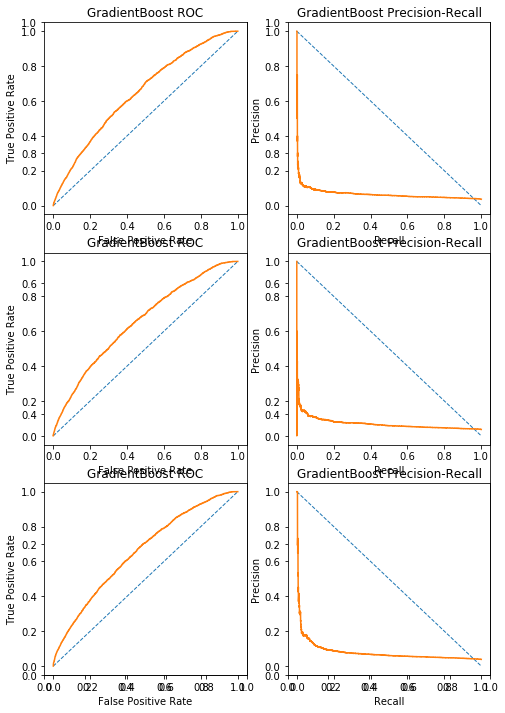

In [43]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 12))

neutral_line = np.linspace(0, 1, 10)

ginis = []
subplot_counter = 1

for i in range(5):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis.append(my_gini(y_test, y_proba2))
    print('Round%d Gini=%.3f' % (i+1, ginis[i]))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    
    ax1 = fig.add_subplot(3, 2, subplot_counter)
    ax2 = fig.add_subplot(3, 2, subplot_counter+1)
    
    ax1.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax2.plot(neutral_line, 1-neutral_line, lw=1, ls='--')
    
    ax1.plot(fpr2, tpr2)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('GradientBoost ROC')
    
    ax2.plot(recall2, precision2)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('GradientBoost Precision-Recall')
    
    subplot_counter += 2
    
plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis), np.std(ginis), np.max(ginis)))

### Predict and save

In [39]:
X_test = np.array(new_test.iloc[:, 1:])
y_ids = np.array(new_test.id)

In [40]:
X_test.shape, y_ids.shape

((892816, 9), (892816,))

In [41]:
y_probas = clf.predict_proba(X_test)

prediction_result = pd.DataFrame({'id': y_ids, 'target': y_probas[:, 1]})
prediction_result = prediction_result[['id', 'target']]

prediction_result.head(10)

,id,target
0,0,0.587573
1,1,0.768533
2,2,0.629555
3,3,0.658339
4,4,0.711899
5,5,0.772068
6,6,0.540385
7,8,0.767240
8,10,0.819875
9,11,0.852939


In [42]:
prediction_result.to_csv('./submissions/porto_seguro_submission_RH12.csv', index=False, header=True)

### Got terrible result. I guess I'd need to go back to 1st submission space...